<a href="https://colab.research.google.com/github/KennyOgun/sentiment_analysis/blob/main/mayfair_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries and Packages

In [2]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.1 MB/s eta 0:00:00


In [3]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=ccd5aba3da54adfc8d78851c2fd5dce93e42e2503a9f4186ee81bbd9bc38a9ff
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [4]:
import nltk

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from transformers import pipeline

from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [7]:
#nltk.download('punkt_tab', download_dir='/root/nltk_data')
nltk.download('wordnet', download_dir='/root/nltk_data')
nltk.download('omw-1.4', download_dir='/root/nltk_data')
nltk.download('stopwords', download_dir='/root/nltk_data')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Data and Data Understanding

In [8]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mayfairdataset.csv')
df = pd.DataFrame(data)
df.head()

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
0,6.01E+16,"Same to this one as well, very classy and soft...",5.0,2024-11-08,United States
1,6.01E+16,"Beautiful colors, exactly what I wanted, but ...",4.0,2024-10-15,United States
2,6.01E+16,"This is top notch scarf, so soft and classy no...",5.0,2024-11-08,United States
3,6.01E+16,Item was great; would buy from seller again!,5.0,2024-11-10,United States
4,6.01E+16,Nice item,5.0,2024-10-01,United States


In [18]:
# Print one example where RATING == 1
example_review = df[df['RATING'] == 1]['REVIEW_CONTENT'].iloc[0]
example_review


'I received my package; however, I had to reach out to the seller beforehand regarding their choice of delivery courier, Better Trucks. This company is known for its low ratings and frequent delivery issues. When I raised my concerns with the seller, they completely dismissed them and simply told me to contact my local post office—which makes no sense, as Better Trucks is not a postal service.\n\nAlthough my package did eventually arrive, it was very late in the evening. Due to the seller’s poor customer service and lack of concern for consumer feedback, I will not be ordering from them again. AliExpress used to rely on DHL, a reputable courier, and I’m unsure why that has changed.'

In [19]:
# Print one example where RATING == 3
example_review = df[df['RATING'] == 3]['REVIEW_CONTENT'].iloc[0]
example_review



'I order a 22 and it looks like a 16 inch but other than that it’s very soft. You should but it but if u want a long one grab a 30.'

In [20]:
# Print one example where RATING == 5
example_review = df[df['RATING'] == 5]['REVIEW_CONTENT'].iloc[0]
example_review


'Same to this one as well, very classy and soft, no bad smells. Perfect for my neck too. Vibrant colors '

In [9]:
print(df.shape)

print("--------------")

#check data info
df.info()

(8492, 5)
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8492 entries, 0 to 8491
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REVIEW_ID       8492 non-null   object 
 1   REVIEW_CONTENT  7869 non-null   object 
 2   RATING          8128 non-null   float64
 3   DATE            8492 non-null   object 
 4   COUNTRY         8492 non-null   object 
dtypes: float64(1), object(4)
memory usage: 331.8+ KB


In [10]:
# mising data
df.isnull().sum()

,0
REVIEW_ID,0
REVIEW_CONTENT,623
RATING,364
DATE,0
COUNTRY,0


In [11]:
# code to count duplicates
duplicates = df[df.duplicated()]
print("Number of duplicate rows:", len(duplicates))

Number of duplicate rows: 80


In [25]:
# check the data statistics
df.describe(include='all').round(2)

,REVIEW_ID,REVIEW_CONTENT,RATING,DATE,COUNTRY
count,8492,7869,8128.00,8492,8492
unique,6344,7602,NaN,1056,107
top,6.01E+16,Good,NaN,2025-03-24,United Kingdom
freq,600,37,NaN,143,2935
mean,NaN,NaN,4.41,NaN,NaN
std,NaN,NaN,0.98,NaN,NaN
min,NaN,NaN,1.00,NaN,NaN
25%,NaN,NaN,4.00,NaN,NaN
50%,NaN,NaN,5.00,NaN,NaN
75%,NaN,NaN,5.00,NaN,NaN


# Quick EDA

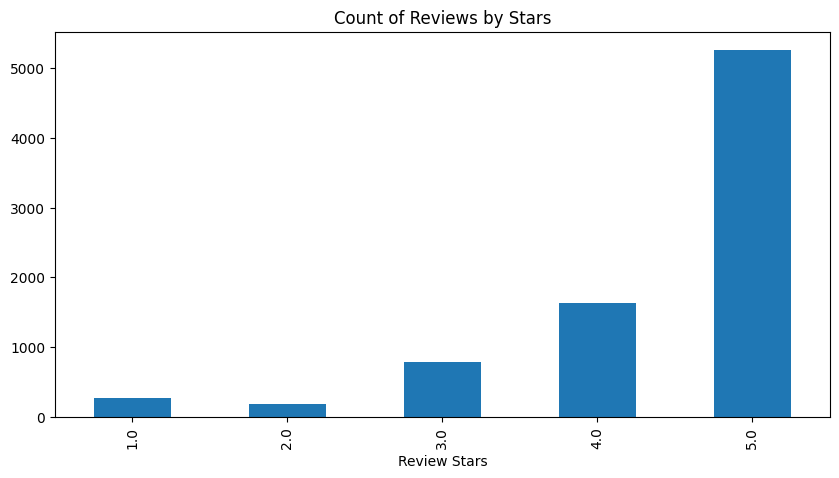

In [27]:
ax = df['RATING'].value_counts().sort_index()\
     .plot(kind='bar',
     title='Count of Reviews by Stars',
     figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

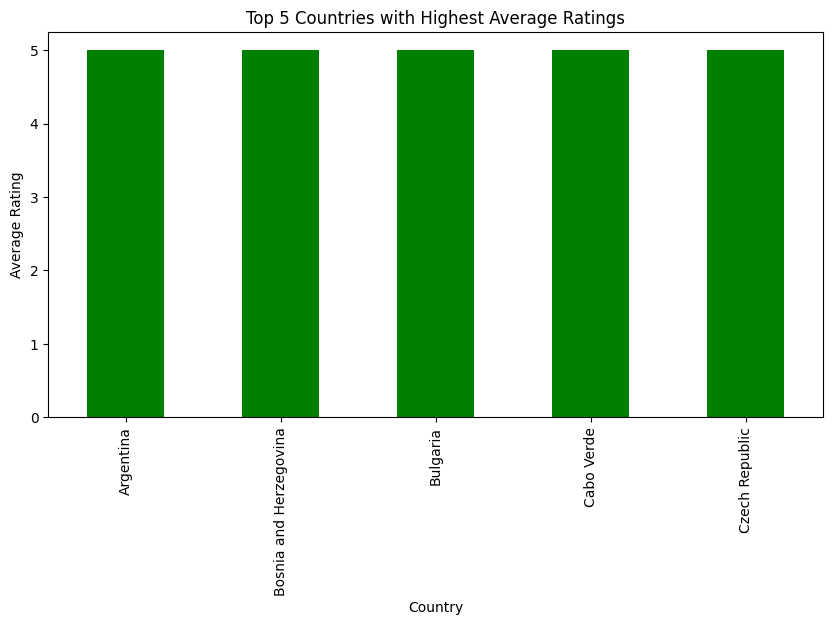

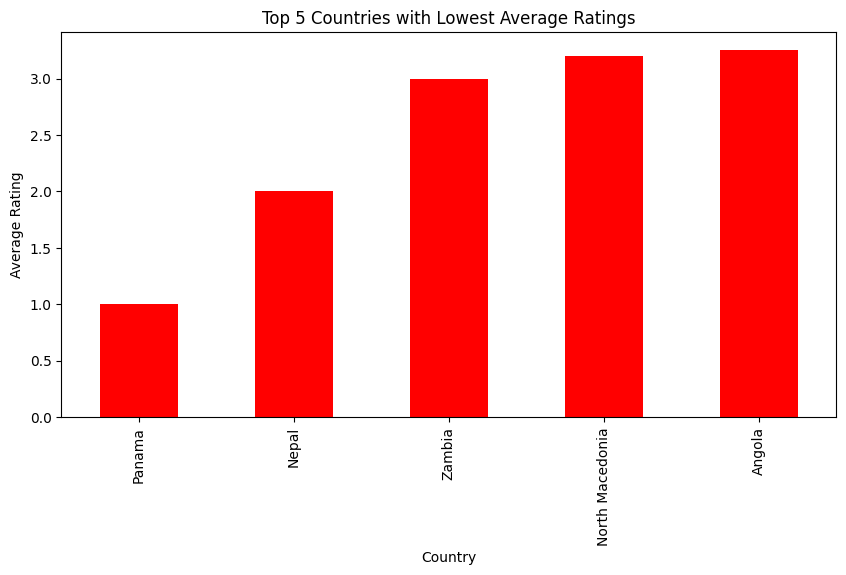

In [31]:
# Top 5 countries with highest ratings
top_5_highest = df.groupby('COUNTRY')['RATING'].mean().nlargest(5)
plt.figure(figsize=(10, 5))
top_5_highest.plot(kind='bar', color='green')
plt.title('Top 5 Countries with Highest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()

# Top 5 countries with lowest ratings
top_5_lowest = df.groupby('COUNTRY')['RATING'].mean().nsmallest(5)
plt.figure(figsize=(10, 5))
top_5_lowest.plot(kind='bar', color='red')
plt.title('Top 5 Countries with Lowest Average Ratings')
plt.xlabel('Country')
plt.ylabel('Average Rating')
plt.show()


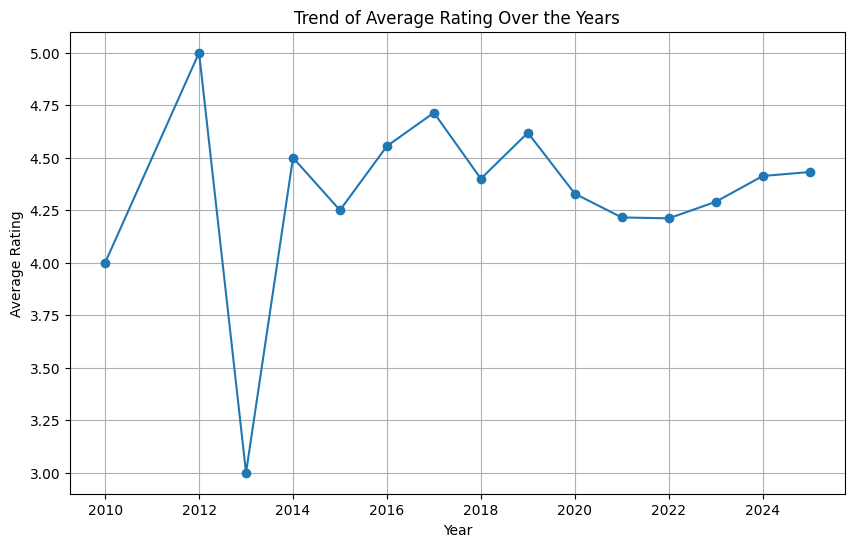

In [32]:
# Convert the date column to datetime objects
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'])
    # Extract the year
    df['YEAR'] = df['DATE'].dt.year

    # Group by year and calculate the mean rating for each year
    yearly_ratings = df.groupby('YEAR')['RATING'].mean()

    # Plot the trend
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.title('Trend of Average Rating Over the Years')
    plt.grid(True)
    plt.show()
elif 'YEAR' in df.columns:
    # Group by year and calculate the mean rating for each year
    yearly_ratings = df.groupby('YEAR')['RATING'].mean()

    # Plot the trend
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_ratings.index, yearly_ratings.values, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.title('Trend of Average Rating Over the Years')
    plt.grid(True)
    plt.show()
else:
    print("No 'DATE' or 'YEAR' column found in the DataFrame.")


In [33]:
# Calculate the length of each review in the 'REVIEW_CONTENT' column
df['review_length'] = df['REVIEW_CONTENT'].astype(str).apply(len)

# Find the minimum and maximum review lengths
min_length = df['review_length'].min()
max_length = df['review_length'].max()

print(f"Minimum review length: {min_length}")
print(f"Maximum review length: {max_length}")


Minimum review length: 1
Maximum review length: 10621


In [35]:
# Find the review with the maximum length
max_length_review = df.loc[df['review_length'].idxmax()]

# Print the 'REVIEW_CONTENT' of the review with the maximum length
#print(max_length_review['REVIEW_CONTENT'])
max_length_review['REVIEW_CONTENT']

'Two years have passed since I reviewed the Amazon Echo Dot Gen 4 and now we have the new Echo Dot Gen 5 so it’s time to revisit the world of Alexa.If you’re familiar with Echo and Alexa, you’ll only be interested in the first part of this review and you can ignore everything after my device appraisal. I’m sure, though, that many people may be new to smart speakers so I’ve also added sections on how to install the Alexa app, how to set up your new speaker and what you can subsequently do with the Echo Dot. My apologies for going over things that you might already know and a lot of this repeats from my previous review, but there will be for which this is new territory.The Device:The Echo speakers have been around for many years now, and despite the best efforts of Google and Apple, Amazon’s Alexa still remains the smart assistant of choice. The most popular of all smart speakers is the Echo Dot. Other bigger and better sounding speakers are available including Amazon’s own larger Echo, 

# 1.0 DATA CLEANING & PREPROCESSING

In [36]:
# Rename columns correctly
df = df.rename(columns={'REVIEW_CONTENT': 'content', 'RATING': 'rating'})

# Subset only the relevant columns
df = df[['content', 'rating']]

# Display the first few rows
df.head()

,content,rating
0,"Same to this one as well, very classy and soft...",5.0
1,"Beautiful colors, exactly what I wanted, but ...",4.0
2,"This is top notch scarf, so soft and classy no...",5.0
3,Item was great; would buy from seller again!,5.0
4,Nice item,5.0


In [37]:
# Ensure language detection consistency
DetectorFactory.seed = 0

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
custom_stopwords = {"would", "shall", "could", "might"}
stop_words.update(custom_stopwords)
stop_words.discard("not")  # Retain "not" for sentiment analysis

### 1. DATA CLEANING & PREPROCESSING ###
# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Remove duplicates & missing values
df = df.drop_duplicates(subset='content', keep='first')
df = df.dropna(subset=['content', 'rating'])
df = df[df['content'].apply(is_english)]  # Keep only English reviews

df['cleaned_review'] = df['content'].apply(clean_text)

### 2. FEATURE ENGINEERING ###

In [38]:
### 2. FEATURE ENGINEERING ###
# Define sentiment labels
df["SENTIMENT"] = df["rating"].apply(lambda x: "Positive" if x >= 4 else "Neutral" if x == 3 else "Negative")

# TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, min_df=10)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["SENTIMENT"]

# Encode sentiment labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature selection (Chi-Square Test, Top 5000 Features)
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

### 3. MODEL SELECTION & TRAINING - LOGISTICS REGRESSION###





In [39]:
### 3. MODEL SELECTION & TRAINING ###
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight={0: np.float64(5.965408805031447),
                                 1: np.float64(3.6551059730250484),
                                 2: np.float64(0.3908117016893284)},
                   max_iter=2000, solver='liblinear')

### 4. MODEL EVALUATION ###

              precision    recall  f1-score   support

           0       0.66      0.47      0.55        79
           1       0.39      0.18      0.25       130
           2       0.90      0.97      0.93      1214

    accuracy                           0.87      1423
   macro avg       0.65      0.54      0.58      1423
weighted avg       0.84      0.87      0.85      1423

AUC Score: 0.8025405084144892


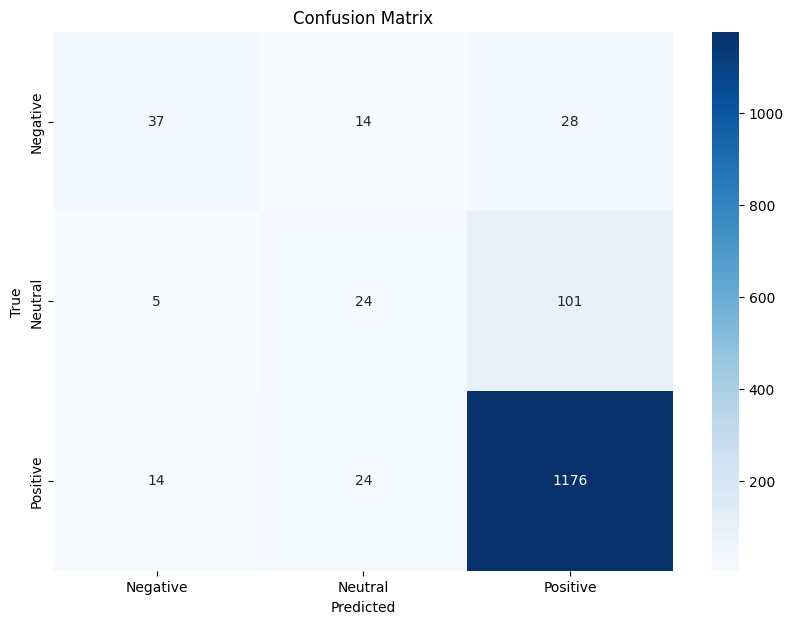

In [46]:
### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# Evaluate Performance
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro"))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# HPERPARAMETER TUNNING- LOGISTICS

Fitting 3 folds for each of 24 candidates, totalling 72 fits


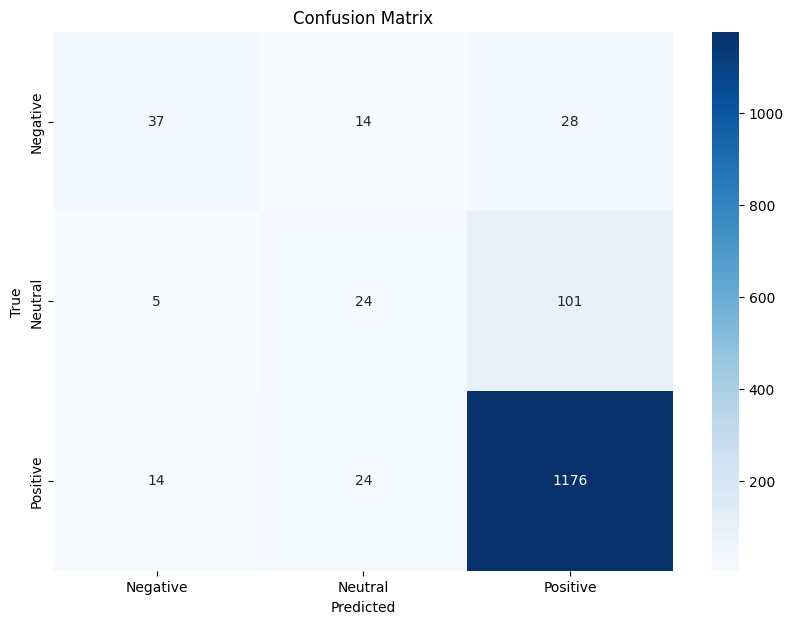

AUC Score: 0.8025405084144892
              precision    recall  f1-score   support

           0       0.66      0.47      0.55        79
           1       0.39      0.18      0.25       130
           2       0.90      0.97      0.93      1214

    accuracy                           0.87      1423
   macro avg       0.65      0.54      0.58      1423
weighted avg       0.84      0.87      0.85      1423



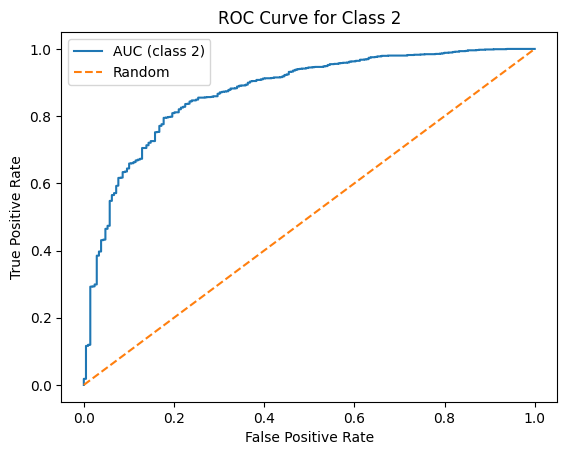

In [49]:
# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=5000, solver="liblinear", C=1.0)

# Hyperparameter Tuning via GridSearchCV (Optional but recommended)
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0],
    'max_iter': [1000, 2000, 5000],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
log_reg_best = grid_search.best_estimator_

# Train the best model
log_reg_best.fit(X_train, y_train)

### 4. MODEL EVALUATION ###
# Make Predictions
y_pred = log_reg_best.predict(X_test)
y_prob = log_reg_best.predict_proba(X_test)


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
print("AUC Score:", auc_score)

# Classification Report
print(classification_report(y_test, y_pred))

# Plotting AUC-ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 2], pos_label=2)  # Choose one class (Positive)
plt.plot(fpr, tpr, label='AUC (class 2)')
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Class 2')
plt.legend()
plt.show()


# VOTING AND STACKING CLASSIFIER USING LOGISTICS AND XGBOOST

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:49:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:50:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:50:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:50:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:51:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh

Stacking Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.48      0.57        79
           1       0.32      0.05      0.08       130
           2       0.89      0.99      0.93      1214

    accuracy                           0.87      1423
   macro avg       0.63      0.50      0.53      1423
weighted avg       0.82      0.87      0.84      1423

Stacking Classifier AUC Score: 0.7848750806746135

Voting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.27      0.40        79
           1       0.24      0.05      0.09       130
           2       0.88      0.99      0.93      1214

    accuracy                           0.86      1423
   macro avg       0.64      0.44      0.47      1423
weighted avg       0.81      0.86      0.82      1423

Voting Classifier AUC Score: 0.7957601914695319


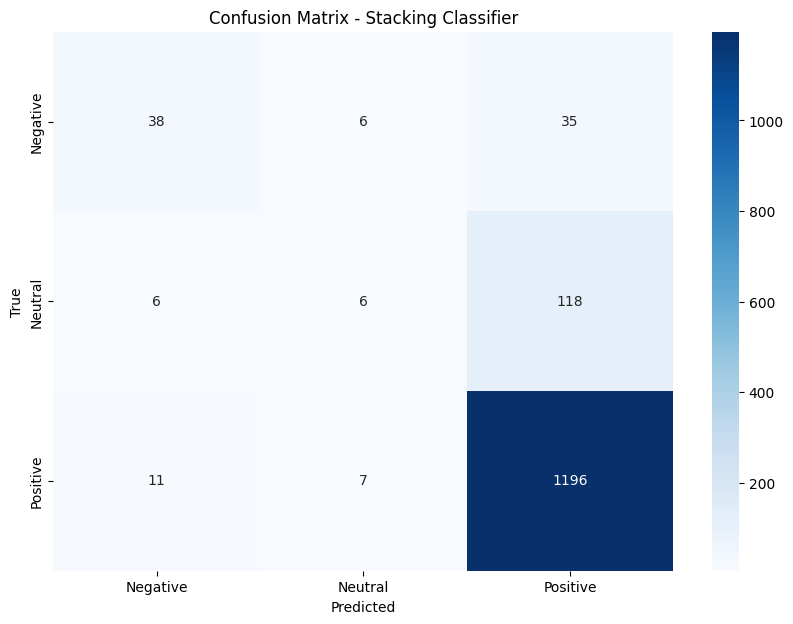

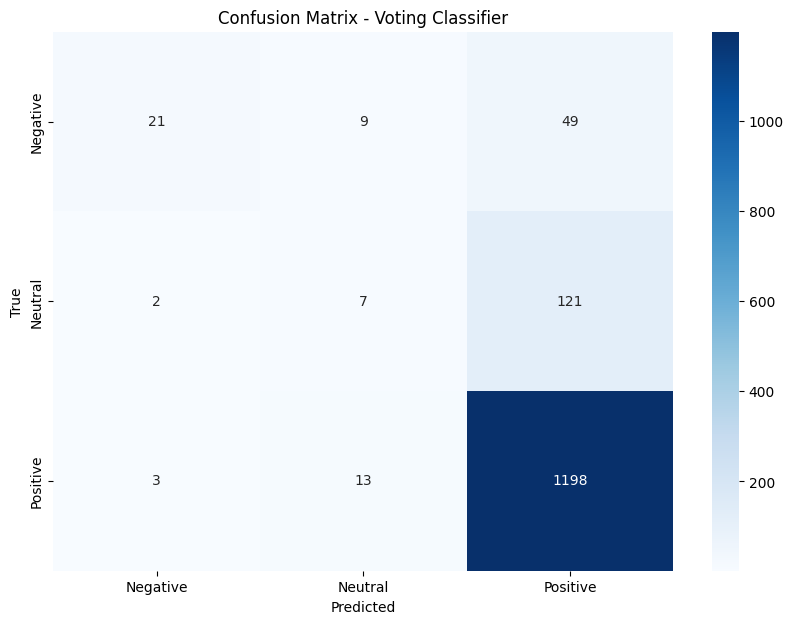

In [50]:
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression


# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 1. Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=2000, solver="liblinear", C=1.0)

# 2. XGBoost Model
xgb_model = xgb.XGBClassifier(scale_pos_weight=class_weights[1], objective='multi:softmax', num_class=3, random_state=42)

# 3. Stacking Classifier (Logistic Regression as meta-model)
stacking_clf = StackingClassifier(estimators=[('log_reg', log_reg), ('xgb', xgb_model)], final_estimator=LogisticRegression())

# 4. Voting Classifier (Soft voting)
voting_clf = VotingClassifier(estimators=[('log_reg', log_reg), ('xgb', xgb_model)], voting='soft')

# Train and evaluate Stacking Classifier
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
y_prob_stack = stacking_clf.predict_proba(X_test)

# Train and evaluate Voting Classifier (soft voting)
voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)
y_prob_vote = voting_clf.predict_proba(X_test)

# Compare performance using classification reports and AUC Scores
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stack))
print("Stacking Classifier AUC Score:", roc_auc_score(y_test, y_prob_stack, multi_class="ovo", average="macro"))

print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, y_pred_vote))
print("Voting Classifier AUC Score:", roc_auc_score(y_test, y_prob_vote, multi_class="ovo", average="macro"))

# Confusion Matrix for Stacking Classifier
cm_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_stack, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Confusion Matrix for Voting Classifier
cm_vote = confusion_matrix(y_test, y_pred_vote)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_vote, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# BINARY(POSTIVE & NEGATIVE) CLASS SENTIMENT ANALYSIS OPTION

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fitting 3 folds for each of 24 candidates, totalling 72 fits


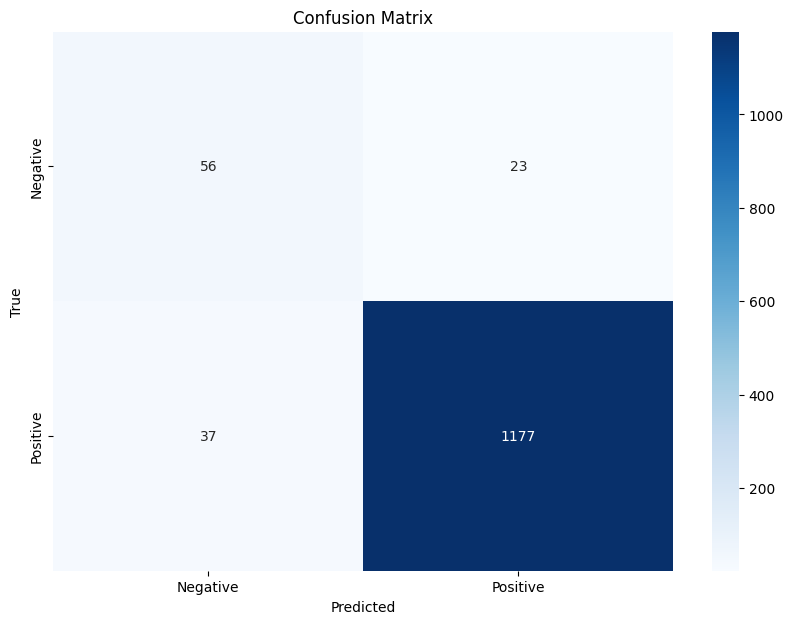

AUC Score: 0.9496121202010301
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        79
           1       0.98      0.97      0.98      1214

    accuracy                           0.95      1293
   macro avg       0.79      0.84      0.81      1293
weighted avg       0.96      0.95      0.96      1293



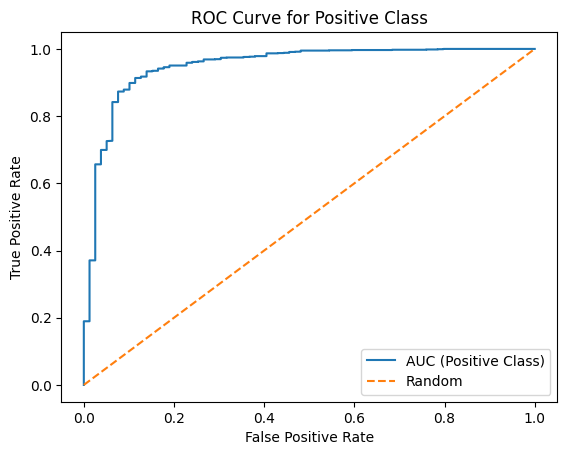

In [51]:
# Ensure language detection consistency
DetectorFactory.seed = 0

# Download required NLTK data
nltk.download("wordnet")
nltk.download("stopwords")

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
custom_stopwords = {"would", "shall", "could", "might"}
stop_words.update(custom_stopwords)
stop_words.discard("not")  # Retain "not" for sentiment analysis

### 1. DATA CLEANING & PREPROCESSING ###

# Function to check if a review is in English
def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False

# Function to clean text
def clean_text(text):
    text = text.lower()
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters & numbers
    text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Remove duplicates & missing values
df = df.drop_duplicates(subset='content', keep='first')
df = df.dropna(subset=['content', 'rating'])
df = df[df['content'].apply(is_english)]  # Keep only English reviews

df['cleaned_review'] = df['content'].apply(clean_text)

### 2. FEATURE ENGINEERING ###

# Define sentiment labels for binary classification (Positive vs Negative)
df["SENTIMENT"] = df["rating"].apply(lambda x: "Positive" if x >= 4 else "Negative" if x <= 2 else None)
df = df.dropna(subset=['SENTIMENT'])  # Drop rows with "None" for neutral

# TF-IDF Vectorization (Unigrams, Bigrams, Trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=15000, min_df=5)  # Increased max_features
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["SENTIMENT"]

# Encode sentiment labels (0: Negative, 1: Positive)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature selection (Chi-Square Test, Top 5000 Features)
chi2_scores, _ = chi2(X, y_encoded)
top_features = np.argsort(chi2_scores)[-5000:]
X_selected = X[:, top_features]

### 3. MODEL SELECTION & TRAINING ###

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute Class Weights (Handles Imbalance)
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train Logistic Regression Model
log_reg = LogisticRegression(class_weight=class_weight_dict, max_iter=5000, solver="liblinear", C=1.0)

# Hyperparameter Tuning via GridSearchCV (Optional but recommended)
param_grid = {
    'C': [0.1, 0.5, 1.0, 5.0],
    'max_iter': [1000, 2000, 5000],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from GridSearchCV
log_reg_best = grid_search.best_estimator_

# Train the best model
log_reg_best.fit(X_train, y_train)

### 4. MODEL EVALUATION ###

# Make Predictions
y_pred = log_reg_best.predict(X_test)
y_prob = log_reg_best.predict_proba(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC-AUC Score
auc_score = roc_auc_score(y_test, y_prob[:, 1])  # Only for Positive class (index 1)
print("AUC Score:", auc_score)

# Classification Report
print(classification_report(y_test, y_pred))

# Plotting AUC-ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1], pos_label=1)  # Positive class (1)
plt.plot(fpr, tpr, label='AUC (Positive Class)')
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Positive Class')
plt.legend()
plt.show()
